In [1]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [3]:
readDatasetObject = ReadDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [4]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

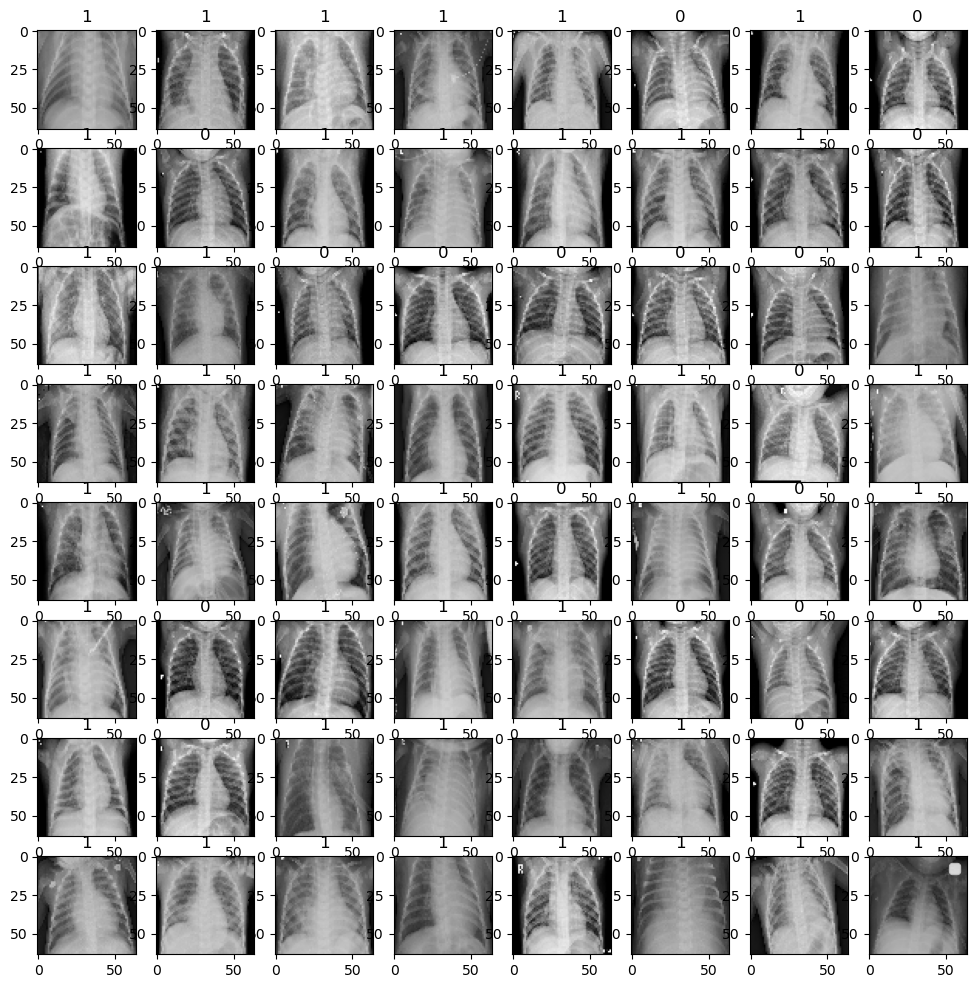

In [5]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [6]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

- Because I didn't have much computational resources, not many Epochs were used.

In [7]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 64000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [8]:
acgan.data(images, labels)

In [9]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   51264       ['leaky_re_lu[0][0]']            
                                                                                      

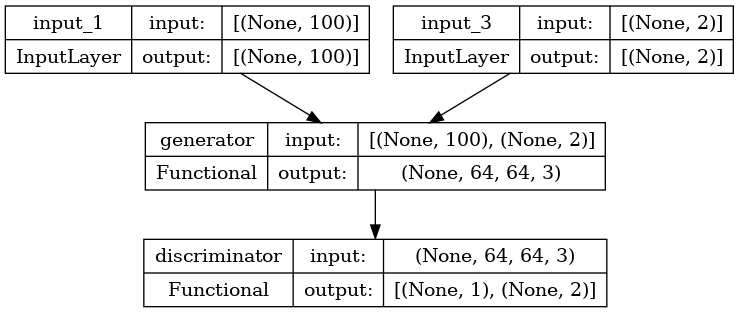

In [10]:
tf.keras.utils.plot_model(GAN, show_shapes = True)

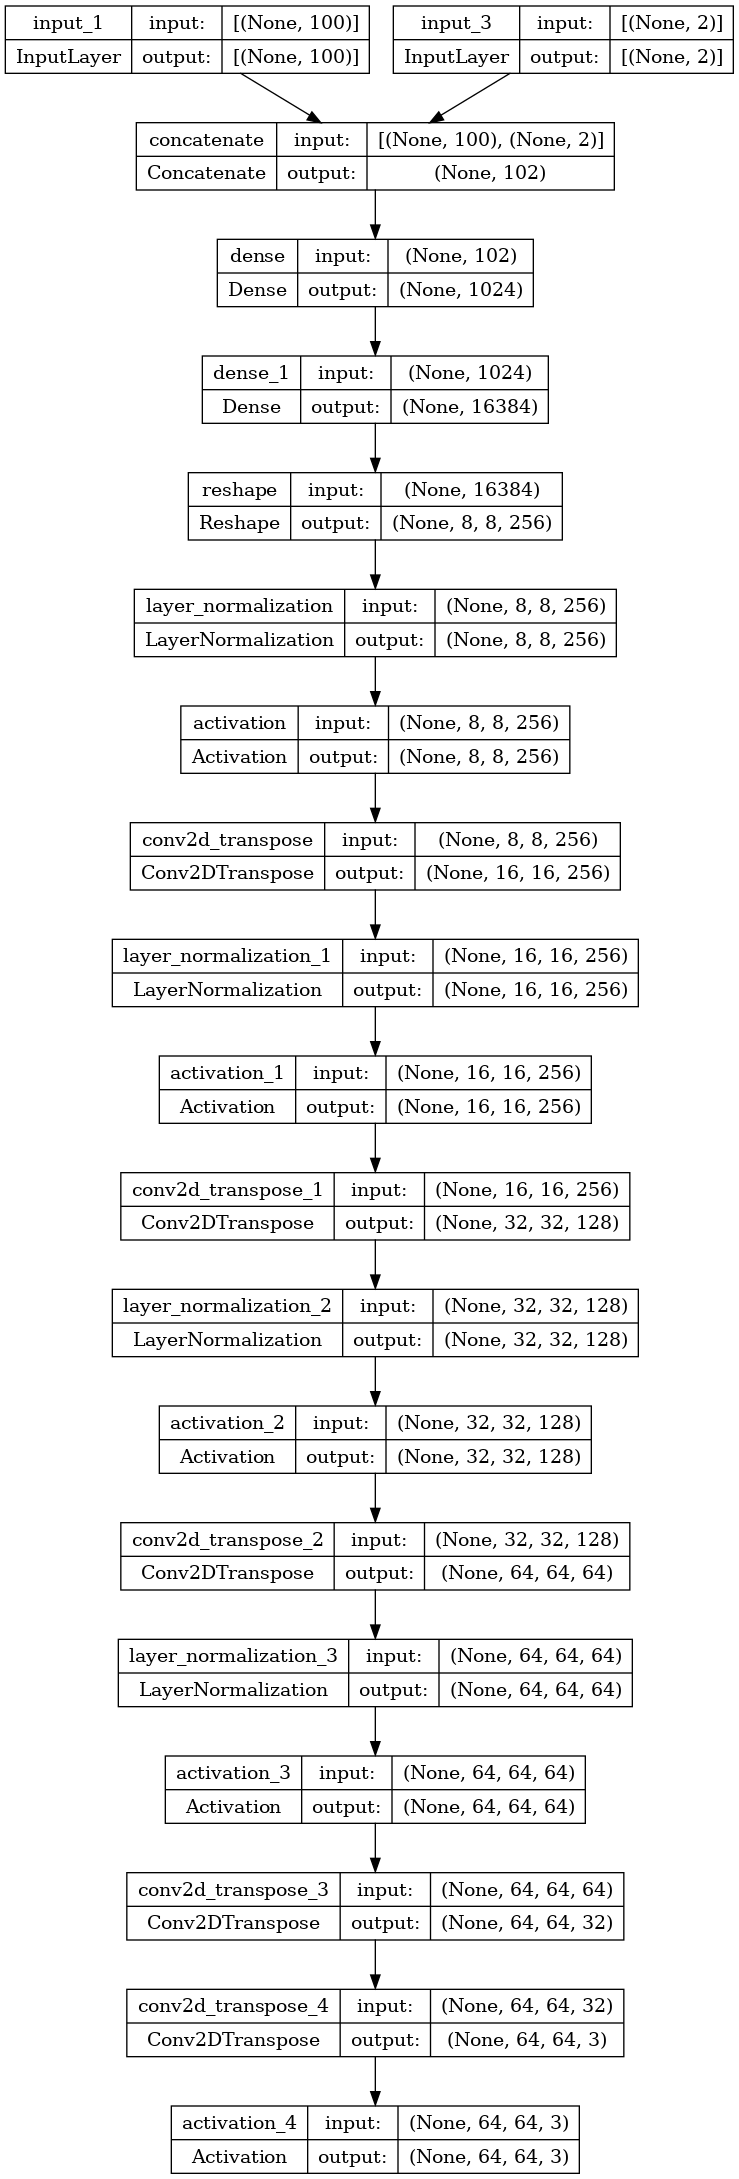

In [11]:
tf.keras.utils.plot_model(G, show_shapes = True)

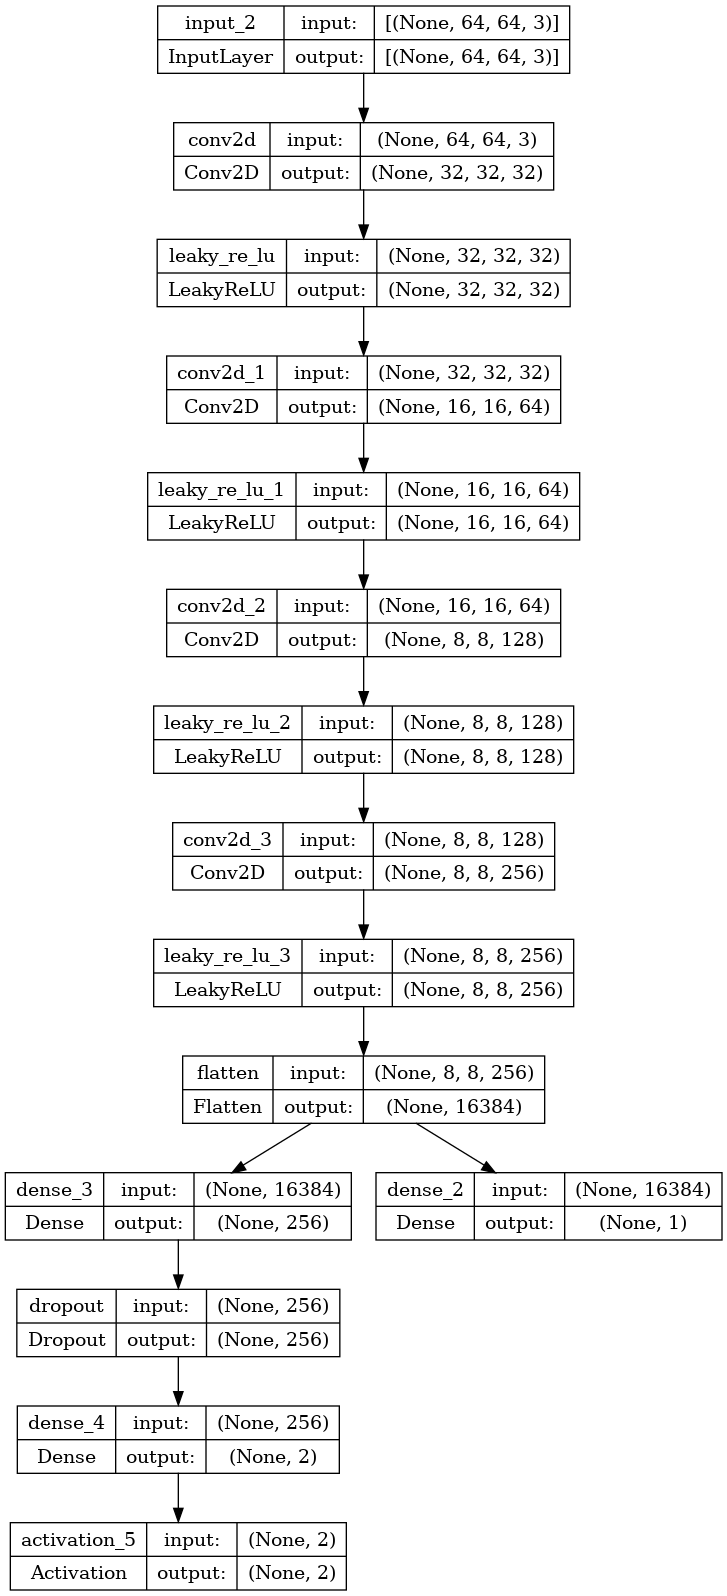

In [12]:
tf.keras.utils.plot_model(D, show_shapes = True)

Epoch: 0
discriminator loss: [tag: 0.47920259833335876, labels: 0.7096980810165405], generator loss: [tag: 0.323025107383728, labels: 0.6404566168785095]
1/1 [==============================] - 0s 19ms/step


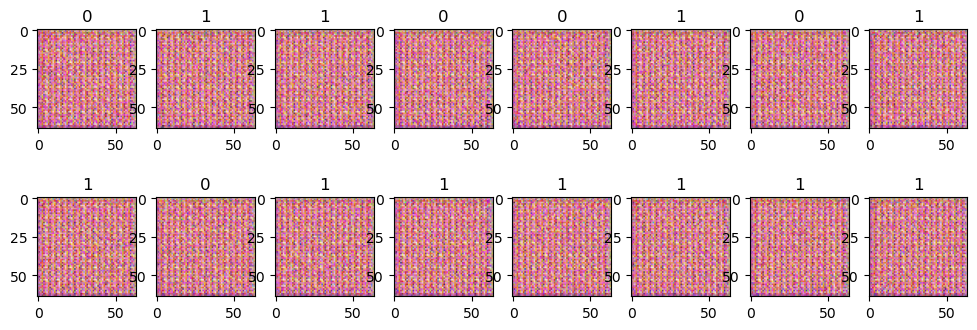

Epoch: 5000
discriminator loss: [tag: 0.22723209857940674, labels: 0.017525771632790565], generator loss: [tag: 0.3163742423057556, labels: 0.011880194768309593]
1/1 [==============================] - 0s 19ms/step


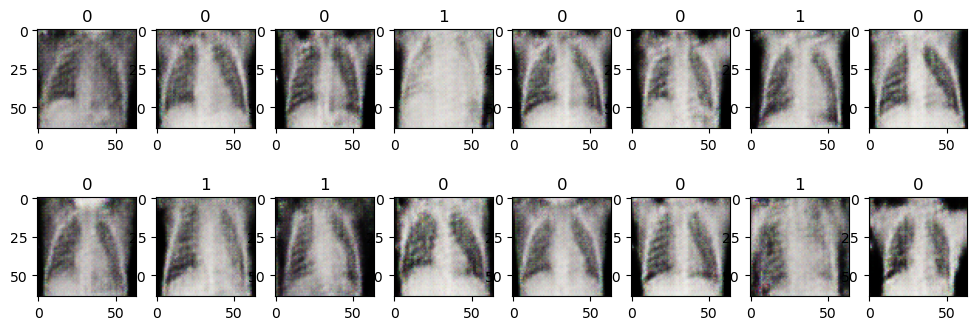

Epoch: 10000
discriminator loss: [tag: 0.22574099898338318, labels: 0.0012470604851841927], generator loss: [tag: 0.3578408360481262, labels: 0.0013644123682752252]
1/1 [==============================] - 0s 20ms/step


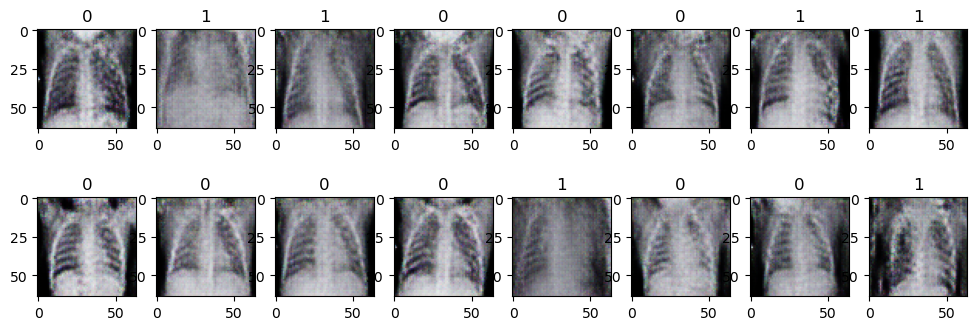

Epoch: 15000
discriminator loss: [tag: 0.2546307444572449, labels: 0.01084188837558031], generator loss: [tag: 0.28319019079208374, labels: 0.000756909663323313]
1/1 [==============================] - 0s 25ms/step


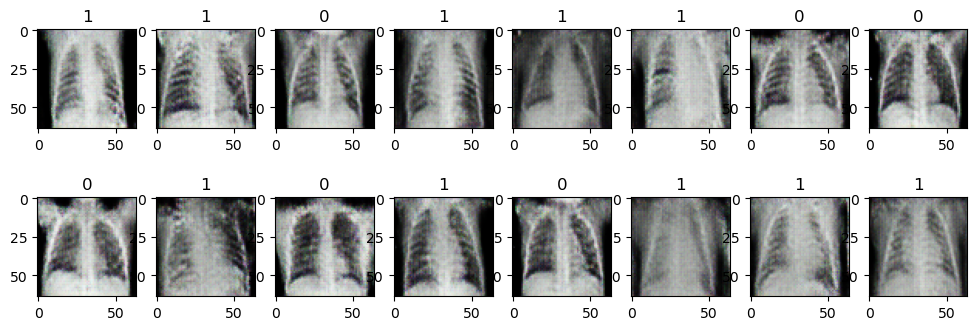

Epoch: 20000
discriminator loss: [tag: 0.23306089639663696, labels: 0.003804675070568919], generator loss: [tag: 0.2992752194404602, labels: 6.091867544455454e-05]
1/1 [==============================] - 0s 18ms/step


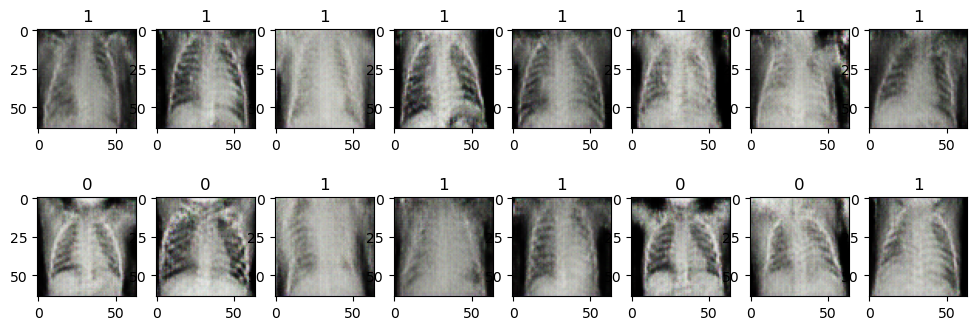

Epoch: 25000
discriminator loss: [tag: 0.20889398455619812, labels: 0.0032110740430653095], generator loss: [tag: 0.2874627411365509, labels: 0.0009017501724883914]
1/1 [==============================] - 0s 20ms/step


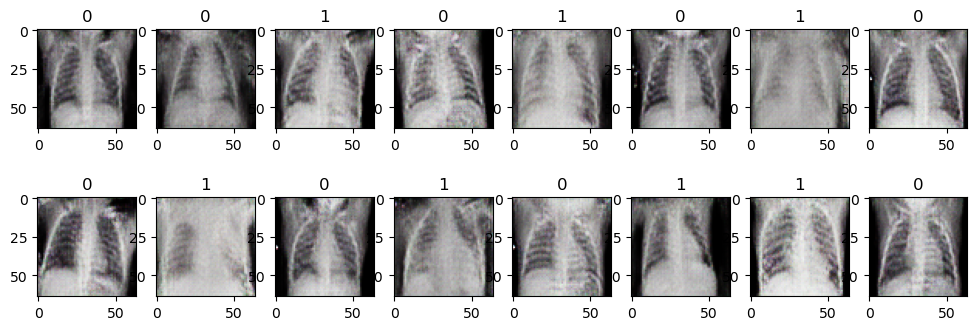

Epoch: 30000
discriminator loss: [tag: 0.1877940446138382, labels: 0.005748166237026453], generator loss: [tag: 0.445097416639328, labels: 0.00018251356959808618]
1/1 [==============================] - 0s 17ms/step


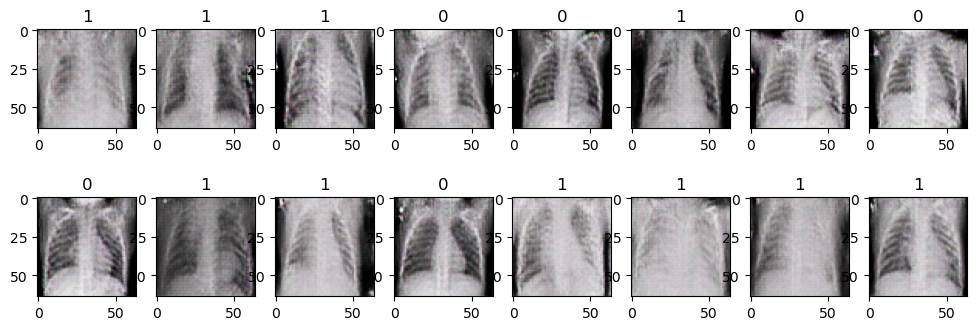

Epoch: 35000
discriminator loss: [tag: 0.14209237694740295, labels: 0.0028290709014981985], generator loss: [tag: 0.6333343982696533, labels: 0.01712234690785408]
1/1 [==============================] - 0s 23ms/step


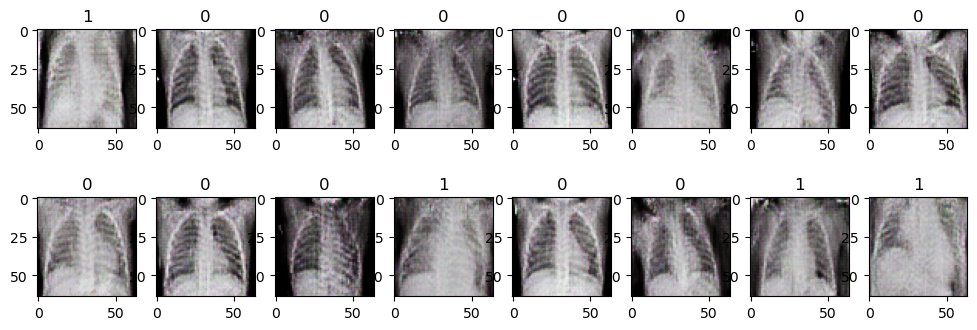

Epoch: 40000
discriminator loss: [tag: 0.23568643629550934, labels: 0.0030042207799851894], generator loss: [tag: 1.2553410530090332, labels: 0.05939958617091179]
1/1 [==============================] - 0s 20ms/step


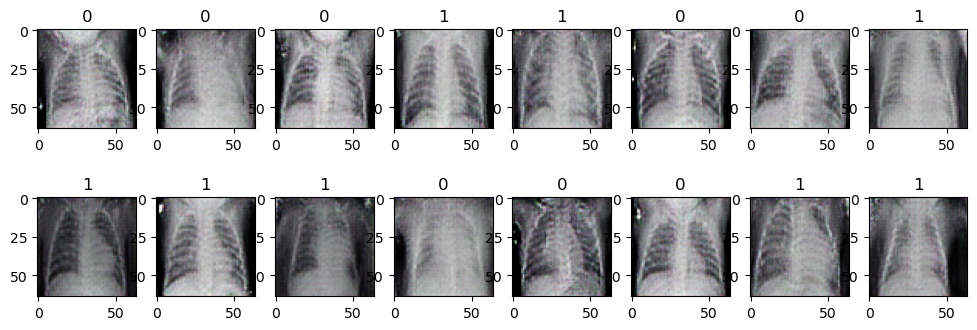

Epoch: 45000
discriminator loss: [tag: 0.09911858290433884, labels: 0.0007111597806215286], generator loss: [tag: 0.8192431926727295, labels: 3.8192461943253875e-05]
1/1 [==============================] - 0s 19ms/step


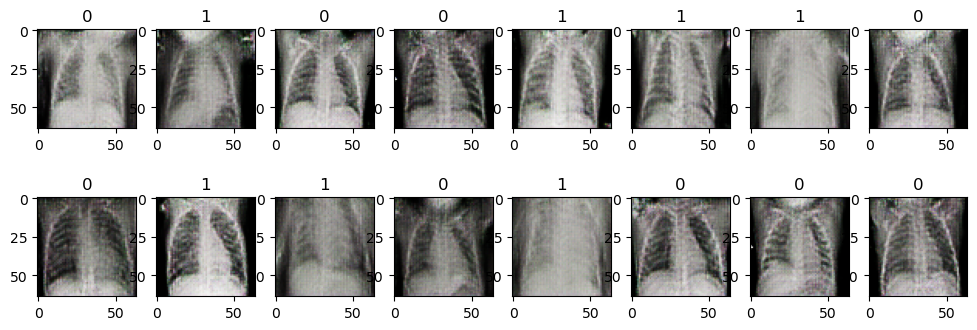

Epoch: 50000
discriminator loss: [tag: 0.08594527095556259, labels: 0.0005011247703805566], generator loss: [tag: 0.5644928216934204, labels: 0.013297835364937782]
1/1 [==============================] - 0s 18ms/step


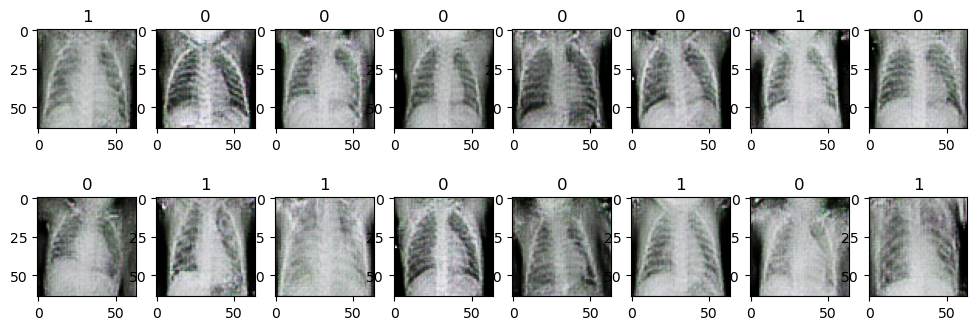

Epoch: 55000
discriminator loss: [tag: 0.11735326051712036, labels: 0.0014804598176851869], generator loss: [tag: 0.855336606502533, labels: 0.0002638529404066503]
1/1 [==============================] - 0s 23ms/step


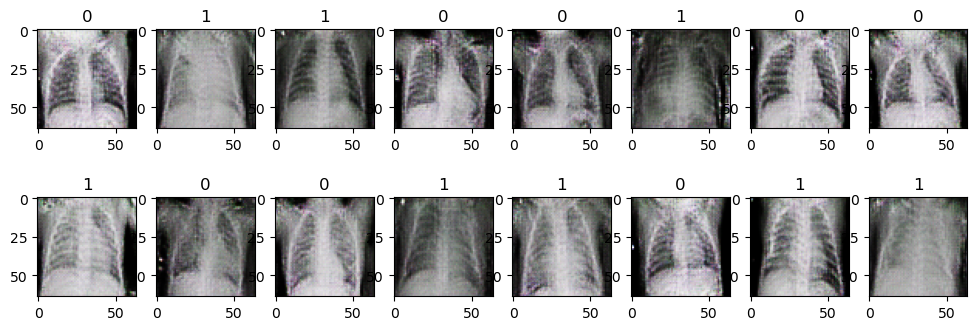

Epoch: 60000
discriminator loss: [tag: 0.05934552848339081, labels: 0.0038165641017258167], generator loss: [tag: 0.8605067729949951, labels: 0.00014284746430348605]
1/1 [==============================] - 0s 18ms/step


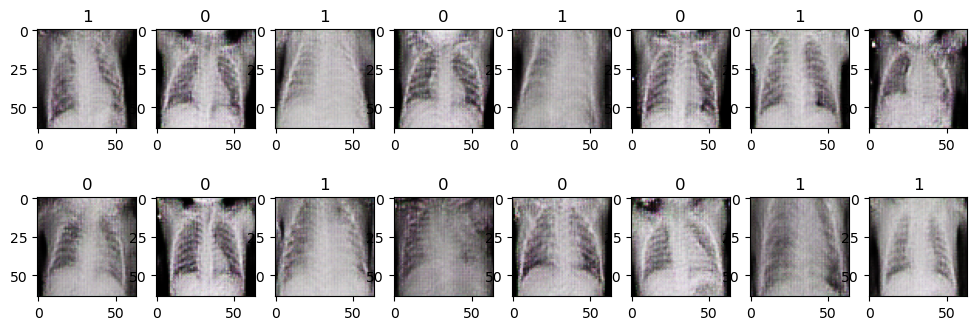

In [13]:
acgan.trainAlgorithm(G, D, GAN)

In [14]:
G.save('/kaggle/working/generator.h5')

In [15]:
G = tf.keras.models.load_model('/kaggle/working/generator.h5')

- We have to make sure that the images that the generator generates are correct, and that they actually include pathological conditions, and this is done by generating a large number of samples, using a neural network to classify the images, and then using the trained neural network, in order to classify the basic images that are included in the basic dataset.

In [16]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [17]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [18]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([14819, 15181]))

In [19]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 15s 16ms/step


(30000, 64, 64, 3)

- Samples generated by the generator for each case (healthy person, person with pneumonia).

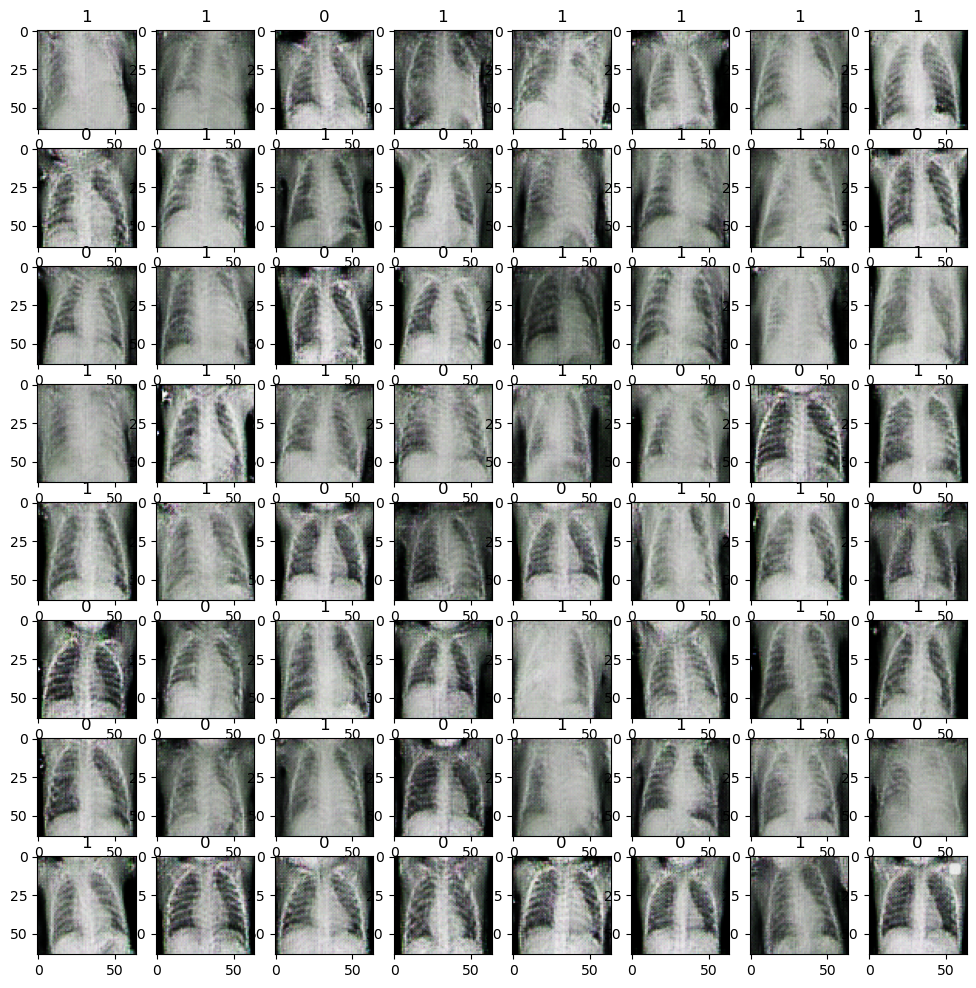

In [20]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In [21]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [22]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 64, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/64
375/375 [==============================] - 27s 50ms/step - loss: 0.2724 - val_loss: 0.5672
Epoch 2/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0733 - val_loss: 0.0662
Epoch 3/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0623 - val_loss: 0.0302
Epoch 4/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0501 - val_loss: 0.0338
Epoch 5/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0436 - val_loss: 0.0270
Epoch 6/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0420 - val_loss: 0.0210
Epoch 7/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0358 - val_loss: 0.0168
Epoch 8/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0330 - val_loss: 0.0172
Epoch 9/64
375/375 [==============================] - 17s 46ms/step - loss: 0.0315 - val_loss: 0.0138
Epoch 10/64
375/375 [==============================] - 17s 46ms/step - loss: 0.029

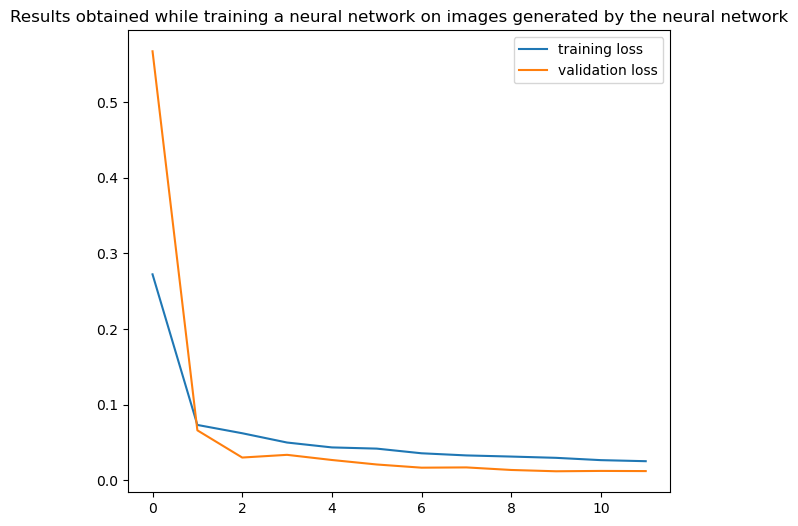

In [23]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [24]:
m.evaluate(images, labels)

163/163 [==============================] - 2s 9ms/step - loss: 0.2300


0.23003752529621124

In [25]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 1s 8ms/step


TensorShape([5216])

In [26]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([1, 0, 0, ..., 0, 1, 1], dtype=int32)

In [27]:
accuracy_score(y_pred, labels)*100

91.71779141104295

In [28]:
print(classification_report(y_pred, labels, digits=4))

              precision    recall  f1-score   support

           0     0.9165    0.7934    0.8505      1549
           1     0.9174    0.9695    0.9427      3667

    accuracy                         0.9172      5216
   macro avg     0.9169    0.8814    0.8966      5216
weighted avg     0.9171    0.9172    0.9153      5216



In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1229,  320],
       [ 112, 3555]])

In [30]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL       1229        320
PNEUMONIA     112       3555

In [31]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 94.27207637231503, recall_score: 96.94573220616307, precision_score: 91.74193548387096


<Axes: >

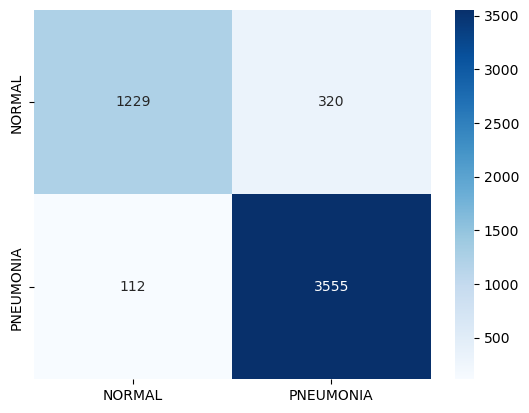

In [32]:
sns.heatmap(cmObject, annot = True, fmt='d', cmap="Blues")